# 0. Setting Up The Env

## 0.1 Packages

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd

import itertools


In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## 0.2 Utilities

In [6]:
def plot_distributions(df, target_col):
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        plt.figure(figsize=(3, 3))
        sns.kdeplot(
            data=df, x=col, hue=target_col,
            common_norm=False, fill=True, alpha=0.4
        )
        plt.title(f"Distribution of {col} by {target_col}")
        plt.show()  

In [7]:
def cap_to_99(df):
    df_capped = df.copy()
    for col in df_capped.columns:
        cap_value = df_capped[col].quantile(0.99)
        df_capped[col] = df_capped[col].clip(upper=cap_value)
    return df_capped


## 0.3 Constants

In [8]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [ ]:
processed_file_path = f"{project_root}/data/processed/preprocessed_bank_2.csv"

processed_file_path

'd:\\01 Work\\06-Segmentations/data/processed/preprocessed_bank.csv'

In [ ]:
capped_file_path = f"{project_root}/data/processed/capped_2.csv"
target_file_path = f"{project_root}/data/processed/target_2.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target.csv')

# 1. The Data

In [11]:
data_df  = pd.read_csv(processed_file_path)
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 4521 rows and 39 columns
Data Preview:


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,0,0,0,1,0,0,0,0,0,1
1,33,0,4789,1,1,11,220,1,339,4,...,1,0,0,1,0,0,1,0,0,0
2,35,0,1350,1,0,16,185,1,330,1,...,0,1,0,1,0,0,1,0,0,0
3,30,0,1476,1,1,3,199,4,-1,0,...,0,1,0,0,0,1,0,0,0,1
4,59,0,0,1,0,5,226,1,-1,0,...,1,0,0,0,0,1,0,0,0,1


In [12]:
data_df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'sin_month', 'cos_month',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown'],
      dtype='object')

# 2. Outlier Analysis

In [13]:
X = data_df.drop("y", axis=1)
y = data_df.loc[:,"y"]

## 2.1 Before Analysis

In [14]:
display(X.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.000000,3.900000e+01,49.0,87.0
default,4521.0,0.016810,0.128575,0.0,0.000000,0.000000e+00,0.0,1.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.000000,4.440000e+02,1480.0,71188.0
housing,4521.0,0.566025,0.495676,0.0,0.000000,1.000000e+00,1.0,1.0
loan,4521.0,0.152842,0.359875,0.0,0.000000,0.000000e+00,0.0,1.0
day,4521.0,15.915284,8.247667,1.0,9.000000,1.600000e+01,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.000000,1.850000e+02,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.000000,2.000000e+00,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.000000,-1.000000e+00,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.000000,0.000000e+00,0.0,25.0


## 2.2 Distribution

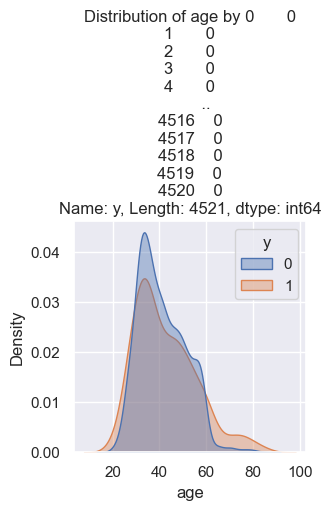

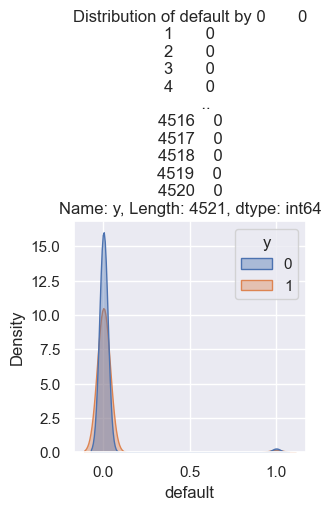

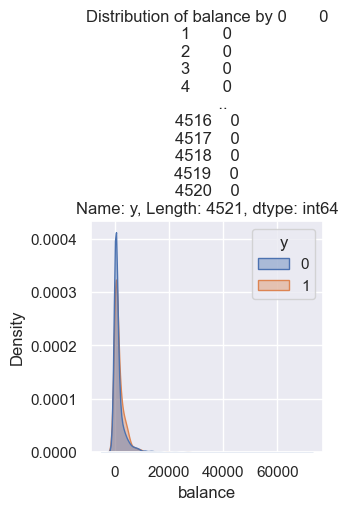

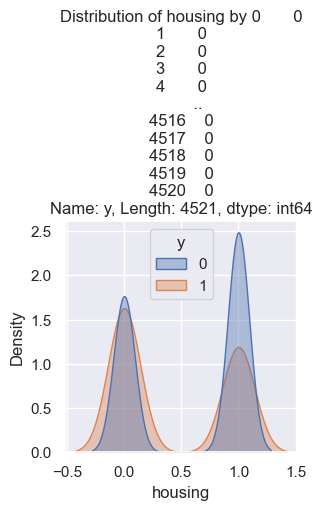

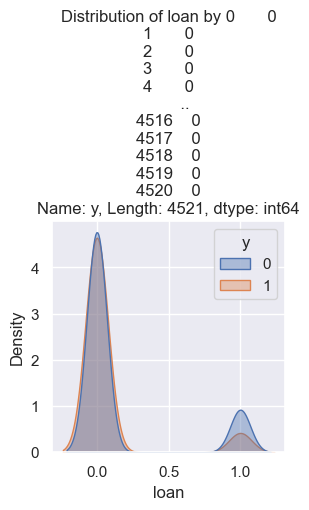

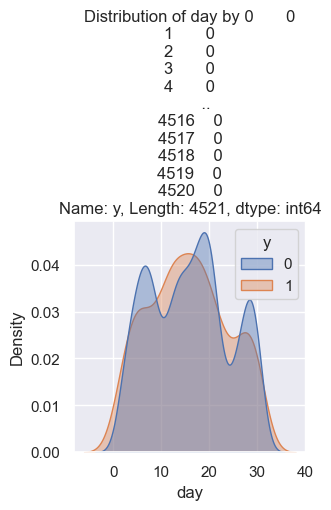

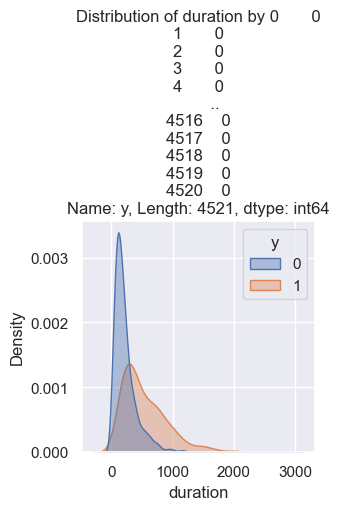

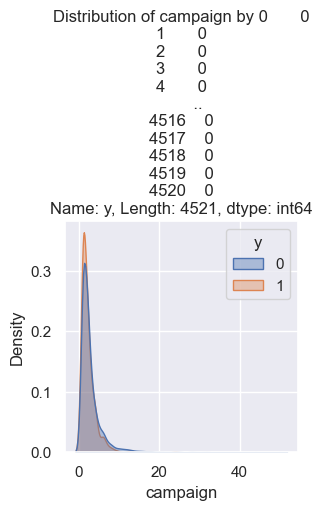

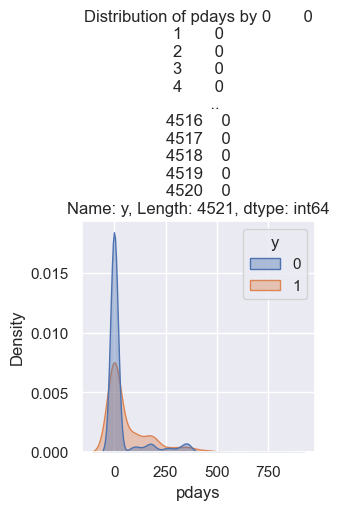

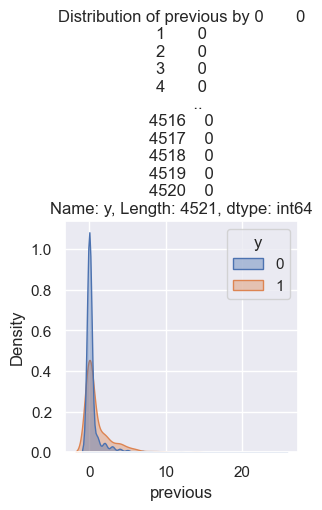

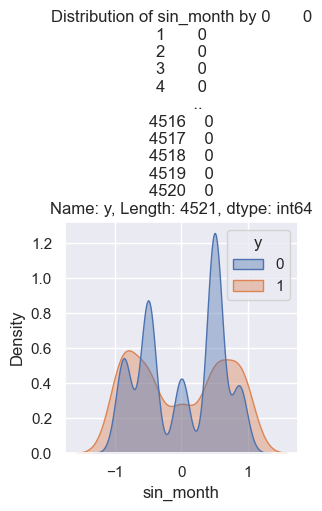

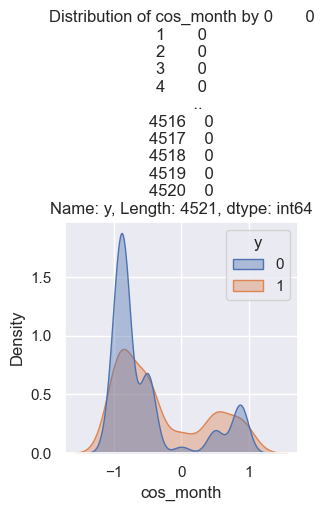

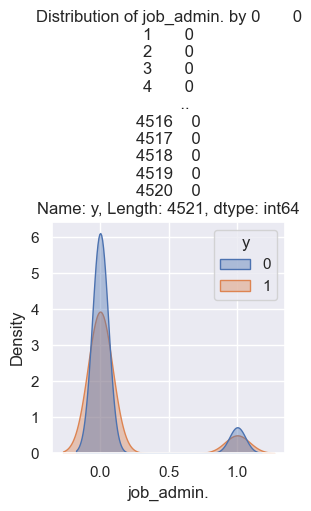

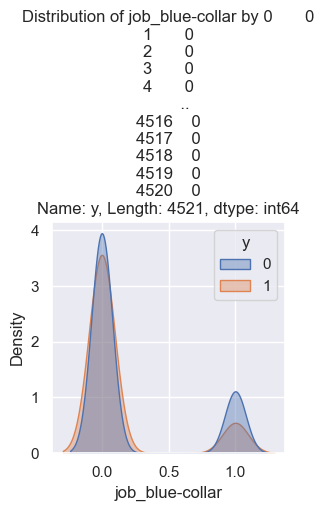

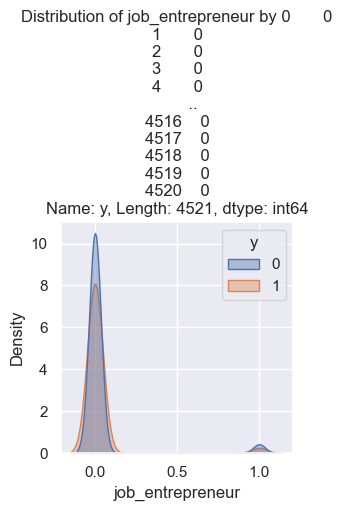

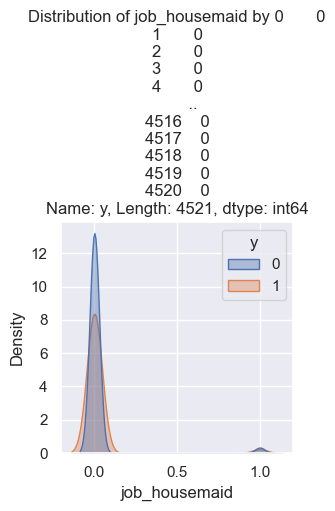

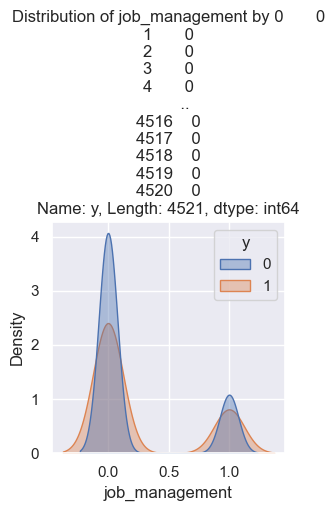

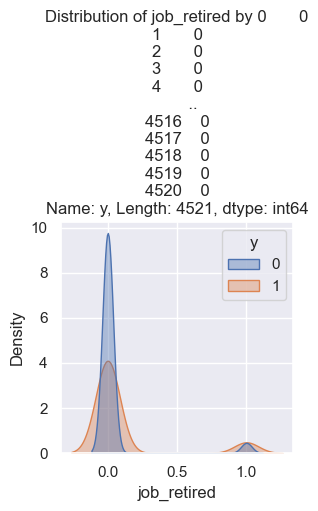

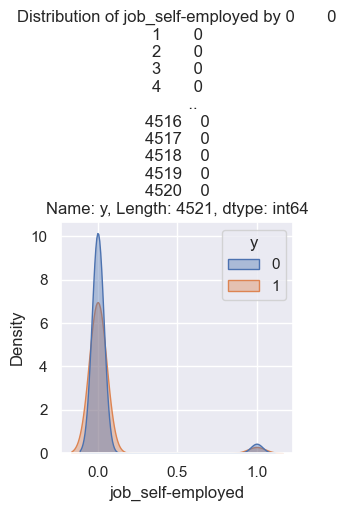

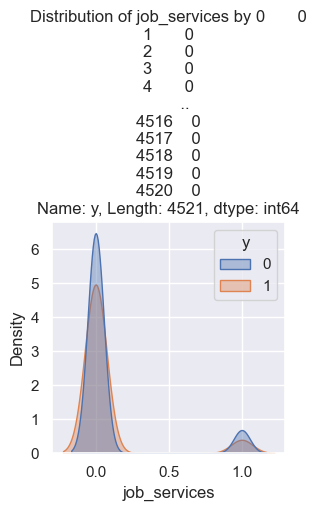

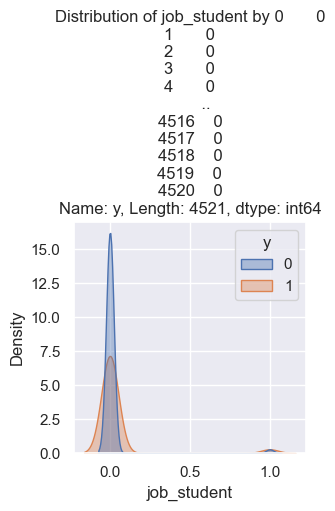

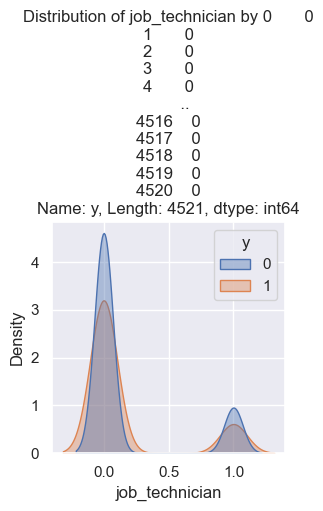

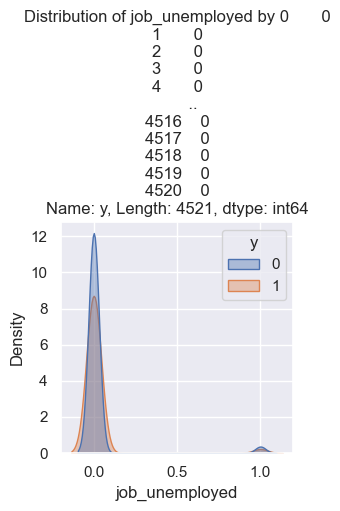

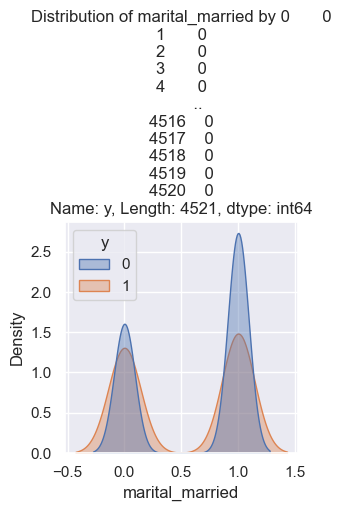

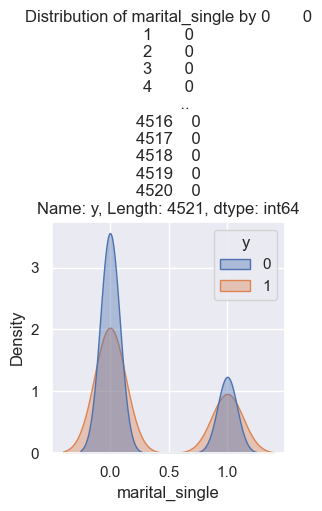

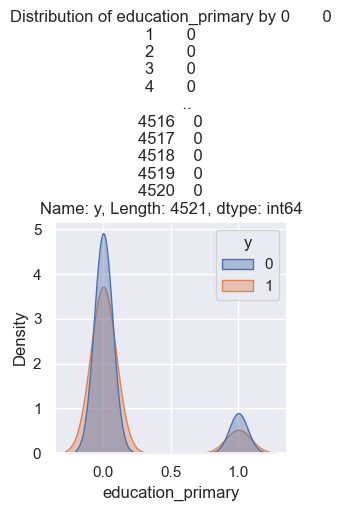

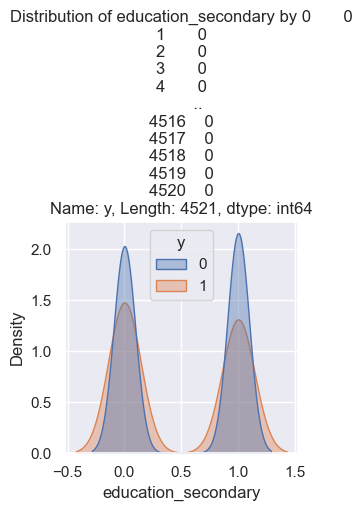

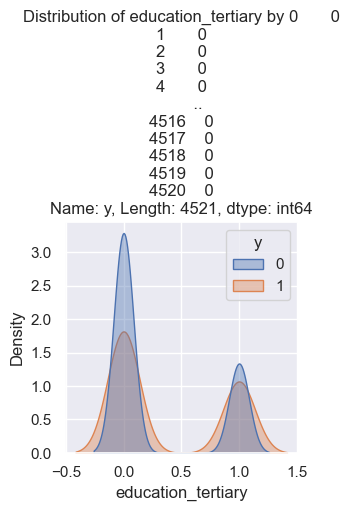

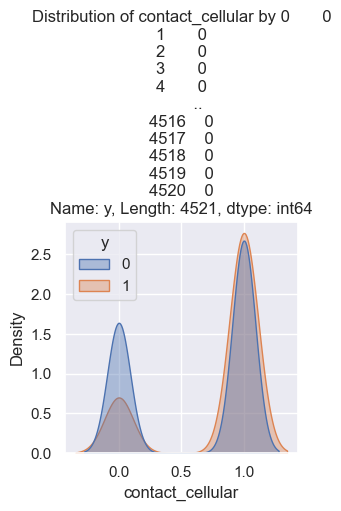

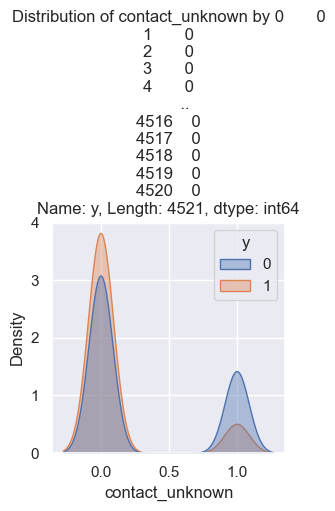

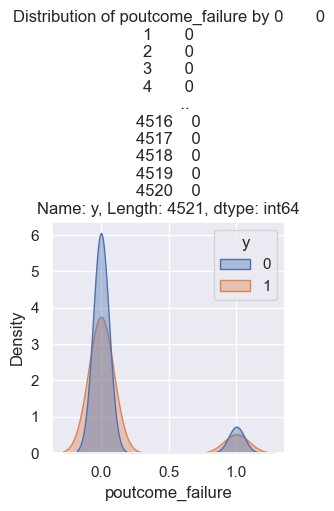

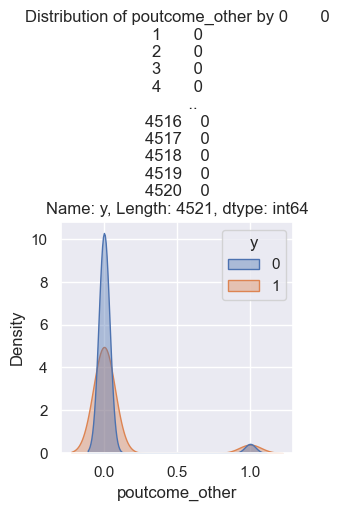

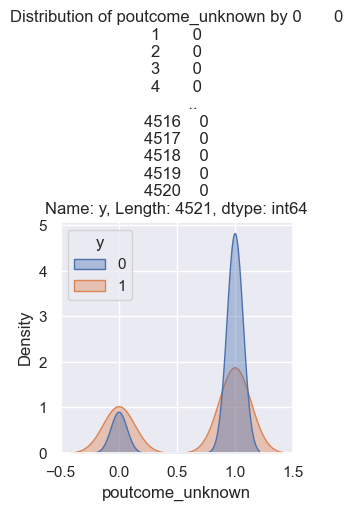

In [15]:
plot_distributions(X, target_col=y)

In [16]:
df_capped = cap_to_99(X)
df_capped.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,30,0,1787.0,0,0,19,79,1,-1,0,...,1,0,1,0,0,1,0,0,0,1
1,33,0,4789.0,1,1,11,220,1,339,4,...,1,0,0,1,0,1,0,1,0,0
2,35,0,1350.0,1,0,16,185,1,330,1,...,0,1,0,0,1,1,0,1,0,0
3,30,0,1476.0,1,1,3,199,4,-1,0,...,1,0,0,0,1,0,1,0,0,1
4,59,0,0.0,1,0,5,226,1,-1,0,...,1,0,0,1,0,0,1,0,0,1


## 2.3 After

In [17]:
display(df_capped.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.113470,10.387607,19.0,33.000000,3.900000e+01,49.0,72.000000
default,4521.0,0.016810,0.128575,0.0,0.000000,0.000000e+00,0.0,1.000000
balance,4521.0,1352.030878,2428.934930,-3313.0,69.000000,4.440000e+02,1480.0,14194.600000
housing,4521.0,0.566025,0.495676,0.0,0.000000,1.000000e+00,1.0,1.000000
loan,4521.0,0.152842,0.359875,0.0,0.000000,0.000000e+00,0.0,1.000000
day,4521.0,15.915284,8.247667,1.0,9.000000,1.600000e+01,21.0,31.000000
duration,4521.0,260.183588,239.270924,4.0,104.000000,1.850000e+02,329.0,1259.000000
campaign,4521.0,2.725061,2.626585,1.0,1.000000,2.000000e+00,3.0,16.000000
pdays,4521.0,38.784119,95.396470,-1.0,-1.000000,-1.000000e+00,-1.0,370.000000
previous,4521.0,0.503871,1.383866,0.0,0.000000,0.000000e+00,0.0,8.000000


# 3. After Plots

In [18]:
X = df_capped

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

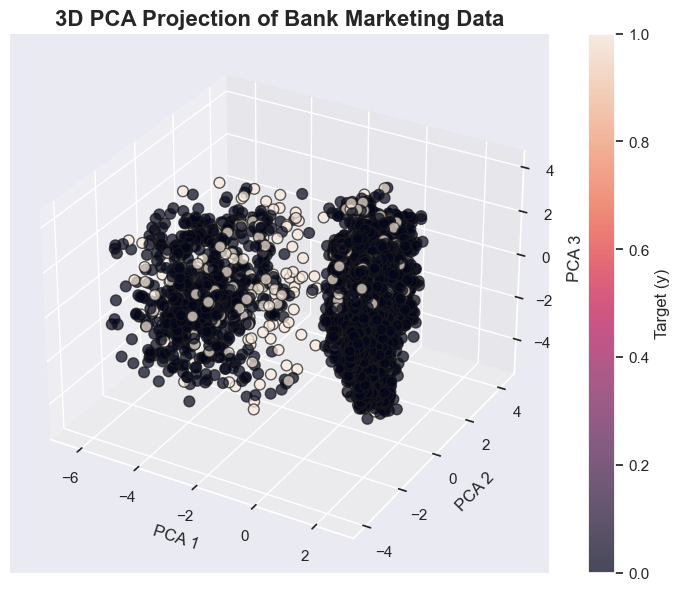

In [20]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

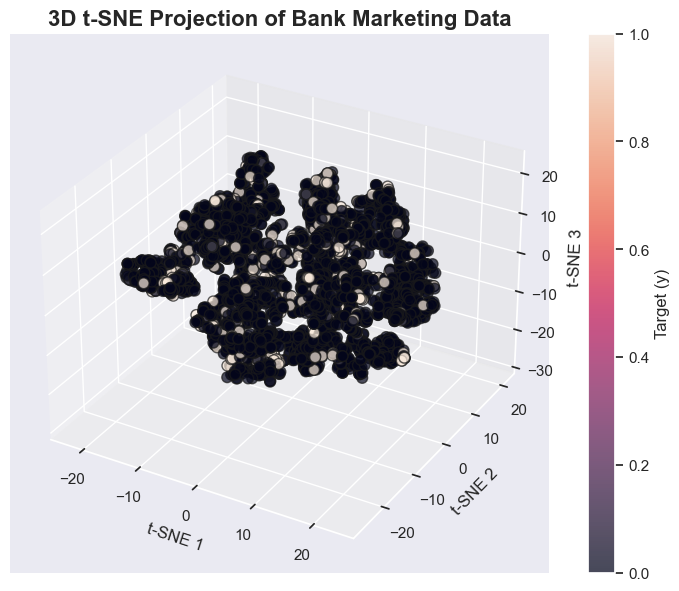

In [21]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2],
    c=y, alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("3D t-SNE Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()


# 4. Save

In [22]:
df_capped.to_csv(capped_file_path, index=False)
y.to_csv(target_file_path, index=False)


# END